In [1]:
import spectrum
import pike as pk
import pike_parallel as parall
import csv
import pandas as pd
from glob import glob
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import PairwiseKernel
import random
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pymzml
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from sklearn.metrics import accuracy_score



In [2]:
def varianceStabilizer(spectrumObject):
    '''Pre-processing function for manipulating intensities.
    Commonly performed to stabilize their variance
    Parameters
    ----------
    SpectrumObject
    
    Returns
    -------
    SpectrumObject with stabilized variance.
    '''
    stabilizer = spectrum.VarStabilizer()
    return stabilizer(spectrumObject)

def baselineRemove( spectrumObject):
    '''Pre-processing function for baseline correction (also referred to as background removal).
    Parameters
    ----------
    SpectrumObject
    
    Returns
    -------
    SpectrumObject.
    '''
    remover = spectrum.BaselineCorrecter(method="SNIP")
    return remover(spectrumObject)

def intensityCalibration( spectrumObject):
    '''Pre-processing function for normalizing the intensity of a spectrum.
    Commonly referred to as total ion current (TIC) calibration.

    Parameters
    ----------
    SpectrumObject
    
    Returns
    -------
    SpectrumObject.
    '''

    calibration = spectrum.Normalizer()
    return calibration(spectrumObject)

def smoother( spectrumObject):
    '''Pre-processing function for smoothing. Uses Savitzky-Golay filter.

    Parameters
    ----------
    SpectrumObject

    Returns
    -------
    SpectrumObject
    '''
    smoother =  spectrum.Smoother()
    return smoother(spectrumObject)

def trimming(spectrumObject):
    '''Pre-processing function for trimming ends of a spectrum.
    This can be used to remove inaccurate measurements.

    Parameters
    ----------
    SpectrumObject
    '''

    trimmer = spectrum.Trimmer()
    return trimmer(spectrumObject)


def binner(spectrumObject):
    '''Pre-processing function for binning spectra in equal-width bins.

    Parameters
    ----------
    spectrumObject
    '''
    binner = spectrum.Binner()
    return binner(spectrumObject)
spectra = spectrum.SpectrumObject()

In [3]:
# Datos del Gregorio Marañon sin extracción de proteínas
semanas = ['Semana 1', 'Semana 2', 'Semana 3']
clases = ['RT023', 'RT027', 'RT078', 'RT106', 'RT165', 'RT181']
medios = ['Medio Ch', 'Medio Br', 'Medio Cl', 'Medio Sc', 'GU']

Y_train = []
baseline = []
samples = []
Y_test = []

for medio in medios:
    for semana in semanas:
        
        for clase in clases:
            
            ruta = f'Z:/bacteria_id/C_diff/Reproducibilidad/ClostiRepro/ClostriRepro/Reproducibilidad No extracción/{medio}/{semana}/{clase}' 
            
            if os.path.exists(ruta):
                for f in os.listdir(ruta):
                    ruta_f = os.path.join(ruta, f)
                    
                    if medio == 'Medio Ch'and semana == 'Semana 1':
                        
                        if 'mzml' in ruta_f:
                            run = pymzml.run.Reader(ruta_f)
                            spectro = [r for r in run]
                            s = spectrum.SpectrumObject(mz=spectro[0].mz, intensity=spectro[0].i)
                            baseline.append(s)
                            Y_train.append(clase)
                        else: 
                            carpetas = [subf for subf in os.listdir(ruta_f)]
                            if carpetas:
                                ruta_f = os.path.join(ruta_f, carpetas[0])
                                # Buscar archivos 'fid' y 'acqu' en las subcarpetas
                                fid_files = glob(os.path.join(ruta_f, '*', '1SLin', 'fid'))
                                acqu_files = glob(os.path.join(ruta_f, '*', '1SLin', 'acqu'))

                                ruta_fid = fid_files[0]
                                ruta_acqu = acqu_files[0]
                                s = spectra.from_bruker(ruta_acqu, ruta_fid)
                                baseline.append(s)
                                Y_train.append(clase)       
                    
                    else:
                        # Si el archivo es un .mzml
                        if 'mzml' in ruta_f:
                            run = pymzml.run.Reader(ruta_f)
                            
                            spectro = [r for r in run]
                            s = spectrum.SpectrumObject(mz=spectro[0].mz, intensity=spectro[0].i)
                            samples.append(s)
                            Y_test.append(clase)
                                    
                                    
                        else: 
                            carpetas = [subf for subf in os.listdir(ruta_f)]
                            
                            ruta_f = os.path.join(ruta, f, carpetas[0])
                            fid_files = glob(os.path.join(ruta_f, '*', '1SLin', 'fid'))
                            acqu_files = glob(os.path.join(ruta_f, '*', '1SLin', 'acqu'))

                            ruta_fid = fid_files[0]
                            ruta_acqu = acqu_files[0]
                            s = spectra.from_bruker(ruta_acqu, ruta_fid)
                            samples.append(s)
                            Y_test.append(clase)
                            



In [4]:
# Datos del Gregorio Marañon con extracción de proteínas

clases = ['RT023', 'RT027', 'RT078', 'RT106', 'RT165', 'RT181']
medios = ['Chx', 'Brx', 'Clx', 'Scx', 'GU']


for medio in medios:
        for clase in clases:
            
            ruta = f'Z:/bacteria_id/C_diff/Reproducibilidad/ClostiRepro/ClostriRepro/Reproducibilidad Extracción/{medio}/{clase}' 
            
            if os.path.exists(ruta):
                for f in os.listdir(ruta):
                    ruta_f = os.path.join(ruta, f)
                    
                        
                    if 'mzml' in ruta_f:
                        run = pymzml.run.Reader(ruta_f)
                        
                        spectro = [r for r in run]
                        s = spectrum.SpectrumObject(mz=spectro[0].mz, intensity=spectro[0].i)
                        samples.append(s)
                        Y_test.append(clase)
                                
                                
                    else: 
                        carpetas = [subf for subf in os.listdir(ruta_f)]
                        
                        ruta_f = os.path.join(ruta, f, carpetas[0])
                        fid_files = glob(os.path.join(ruta_f, '*', '1SLin', 'fid'))
                        acqu_files = glob(os.path.join(ruta_f, '*', '1SLin', 'acqu'))

                        ruta_fid = fid_files[0]
                        ruta_acqu = acqu_files[0]
                        s = spectra.from_bruker(ruta_acqu, ruta_fid)
                        samples.append(s)
                        Y_test.append(clase)
                            



In [5]:
Y_train = np.array(Y_train)
Y_train[Y_train=='RT023']=0
Y_train[Y_train=='RT027']=1
Y_train[Y_train=='RT078']=2
Y_train[Y_train=='RT106']=3
Y_train[Y_train=='RT165']=4
Y_train[Y_train=='RT181']=5


In [6]:
Y_test = np.array(Y_test)
Y_test[Y_test=='RT023']=0
Y_test[Y_test=='RT027']=1
Y_test[Y_test=='RT078']=2
Y_test[Y_test=='RT106']=3
Y_test[Y_test=='RT165']=4
Y_test[Y_test=='RT181']=5

In [7]:
#preporocesado del baseline (no hace falta ejecutarlo)
spec1C_mz = []
spec1C_intensity = []

for i, s in enumerate(baseline):
    
    # Preprocessing: Varaince stab.,smoother, baseline removal, intensity caibration (TIC), trimming
    sO_s1 = varianceStabilizer(s)
    sO_s1 = smoother(sO_s1)
    sO_s1 = baselineRemove(sO_s1)
    sO_s1 = intensityCalibration(sO_s1)
    sO_s1 = trimming(sO_s1)
    # Binning
    sO_s1 = binner(sO_s1)

    spec1C_mz.append(np.array(sO_s1.mz))
    spec1C_intensity.append(np.array(sO_s1.intensity))


spec1C_mz = np.array(spec1C_mz)
spec1C_intensity = np.array(spec1C_intensity)


In [8]:
#preprocesado test samples
specTest_mz = []
specTest_intensity = []
for i, s in enumerate(samples):
    
    
    # Preprocessing: Varaince stab.,smoother, baseline removal, intensity caibration (TIC), trimming
    sO_s1 = varianceStabilizer(s)
    sO_s1 = smoother(sO_s1)
    sO_s1 = baselineRemove(sO_s1)
    sO_s1 = intensityCalibration(sO_s1)
    sO_s1 = trimming(sO_s1)
    # Binning
    sO_s1 = binner(sO_s1)

    specTest_mz.append(np.array(sO_s1.mz))
    specTest_intensity.append(np.array(sO_s1.intensity))


specTest_mz = np.array(specTest_mz)
specTest_intensity = np.array(specTest_intensity)

y:\ClostriRepro\spectrum.py:357: RuntimeWarning: invalid value encountered in divide
  intensity=SpectrumObj.intensity / SpectrumObj.intensity.sum() * self.sum,


In [9]:
n_estimators = [10, 50, 100, 200, 300]

param_grid = {'n_estimators': n_estimators}
loo = LeaveOneOut()
rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=loo, n_jobs=-1)

grid_search.fit(spec1C_intensity, Y_train)
pred = grid_search.predict(specTest_intensity)
accuracy = accuracy_score(Y_test, pred)
print('Accuracy without DA:', accuracy)


Accuracy without DA: 0.6176470588235294


In [10]:
n_estimator = grid_search.best_params_['n_estimators']

# STEP1

Añade ruido a un porcentaje determinado de los picos cuyas intensidades no son cero. Valora distintas desviaciones para el ruido

In [11]:
def stepOne(intensidades, porcentaje):
    '''
    Selecciona los picos de forma aleatoria de acuerdo a un porcentaje de picos.

    Args:
        intensidades: intensidades del espectro
        porcentaje: porcentaje a seleccionar
    '''
    posiciones_no_cero = [index for index, valor in enumerate(intensidades) if valor != 0]
    n_seleccionar = int(len(posiciones_no_cero) * porcentaje)
    posiciones_seleccionadas = random.sample(posiciones_no_cero, n_seleccionar)
    
    return posiciones_seleccionadas

In [12]:
stds = [0.01, 0.05, 0.1, 0.5, 1]
Nshifts = [0, 1, 2, 4,6,8,10,12,14, 16,18,20,22,24,26,28,30,32,34]


In [13]:

rf = RandomForestClassifier(random_state=42, n_estimators=n_estimator)
loo = LeaveOneOut()

acc_N = np.zeros((len(stds), len(Nshifts)))
acc_std = np.zeros((len(stds), len(Nshifts)))


for i, std in enumerate(stds):
    for j, n in enumerate(Nshifts):
        accuracies_combined = []  
        for _ in range(100):
            

            spec1C_mz = []
            spec1C_intensity = []

            for s in baseline:
    
                # Preprocessing: Varaince stab.,smoother, baseline removal, intensity caibration (TIC), trimming
                sO_s1 = varianceStabilizer(s)
                sO_s1 = smoother(sO_s1)
                sO_s1 = baselineRemove(sO_s1)
                sO_s1 = intensityCalibration(sO_s1)
                sO_s1 = trimming(sO_s1)
                # Binning
                sO_s1 = binner(sO_s1)

                spec1C_mz.append(np.array(sO_s1.mz))
                spec1C_intensity.append(np.array(sO_s1.intensity))


            spec1C_mz = np.array(spec1C_mz)
            spec1C_intensity = np.array(spec1C_intensity)

            augmented_spec1C_intensity = []
            augmented_spec1C_mz = []
            augmented_labels = []

            for mz, intensity, label in zip(spec1C_mz, spec1C_intensity, Y_train):
                index = stepOne(intensity, 0.75)
                int_modificados = []
                mz_modificados = []
                Y_modificados = []

                for _ in range(n):
                    intensidades_modificadas = intensity.copy()
                    
                    for pos in index:
                        ruido = np.random.normal(loc=0, scale=std) * intensity[pos]
                        intensidades_modificadas[pos] += ruido

                    int_modificados.append(intensidades_modificadas)
                    mz_modificados.append(mz)
                    Y_modificados.append(label)

                augmented_spec1C_intensity.append(intensity)
                augmented_spec1C_intensity.extend(int_modificados)
                augmented_spec1C_mz.append(mz)
                augmented_spec1C_mz.extend(mz_modificados)
                augmented_labels.append(label)
                augmented_labels.extend(Y_modificados)

            spec1C_mz = np.array(augmented_spec1C_mz)
            spec1C_intensity = np.array(augmented_spec1C_intensity)
            labels_1C = np.array(augmented_labels).reshape(-1, 1)

            # Entrenar el modelo
            rf.fit(spec1C_intensity, labels_1C.ravel())

            # Evaluación del modelo
            combined_score = rf.score(specTest_intensity, Y_test.ravel())
            accuracies_combined.append(combined_score)

       
        mean_accuracy = 100 * np.mean(accuracies_combined)
        std_accuracy = 100 * np.sqrt(np.var(accuracies_combined))
        
        acc_N[i, j] = mean_accuracy
        acc_std[i, j] = std_accuracy


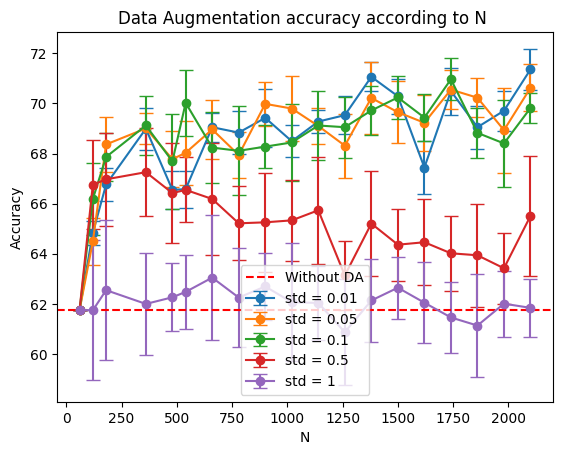

In [14]:
N =[ 60, 120, 180, 360, 480, 540, 660,  780, 900, 1020, 1140, 1260, 1380, 1500, 1620, 1740, 1860, 1980, 2100 ]


fig, ax = plt.subplots()

for i, std in enumerate(stds):  
    ax.errorbar(N, acc_N[i, :], yerr=acc_std[i, :], fmt='-o', capsize=5, label=f'std = {std}')

ax.axhline(y=61.76, color='r', linestyle='--', label='Without DA')
ax.set_xlabel('N')
ax.set_ylabel('Accuracy')
ax.set_title('Data Augmentation accuracy according to N ')
ax.legend()
plt.show()

# STEP 2

shifting de las posiciones aleatoriamente 3 Da, 6 Da o 9 Da o no las intercambia, en función de distintos porcentajes para cada caso

In [15]:
acc_N = np.zeros((2, len(Nshifts)))
acc_std = np.zeros((2, len(Nshifts)))

In [17]:

rf = RandomForestClassifier(random_state=42, n_estimators=150)
loo = LeaveOneOut()

for j, n in enumerate(Nshifts):
    accuracies_combined = []  
    for _ in range(100):

        spec1C_mz = []
        spec1C_intensity = []

        for s in baseline:

            # Preprocessing: Variance stab., smoother, baseline removal, intensity calibration (TIC), trimming
            sO_s1 = varianceStabilizer(s)
            sO_s1 = smoother(sO_s1)
            sO_s1 = baselineRemove(sO_s1)
            sO_s1 = intensityCalibration(sO_s1)
            sO_s1 = trimming(sO_s1)
            # Binning
            sO_s1 = binner(sO_s1)

            spec1C_mz.append(np.array(sO_s1.mz))
            spec1C_intensity.append(np.array(sO_s1.intensity))

        spec1C_mz = np.array(spec1C_mz)
        spec1C_intensity = np.array(spec1C_intensity)

        augmented_spec1C_intensity = []
        augmented_spec1C_mz = []
        augmented_labels = []
        n_shift = spec1C_mz.shape[1]
        n_50 = int(n_shift * 0.60)
        n_30 = int(n_shift * 0.20)
        n_15 = int(n_shift * 0.10)
        n_5 = int(n_shift * 0.10)
        # Permutar aleatoriamente los índices para seleccionarlos
        indices = np.random.permutation(n_shift)
        indices_50 = indices[:n_50]
        indices_30 = indices[n_50:n_50 + n_30]
        indices_15 = indices[n_50 + n_30:n_50 + n_30 + n_15]
        indices_5 = indices[n_50 + n_30 + n_15:] 

        for mz, intensity, label in zip(spec1C_mz, spec1C_intensity, Y_train):
            
            int_modificados = []
            mz_modificados = []
            Y_modificados = []


            shifted_mz  = mz.copy()
            # Desplazar el 30% en ±3 Da
            desplazamiento_20 = np.random.uniform(-3, 3, size=n_30)
            shifted_mz[indices_30] += desplazamiento_20

            # Desplazar el 15% en ±60 Da
            desplazamiento_10_1 = np.random.uniform(-6, 6, size=n_15)
            shifted_mz[indices_15] += desplazamiento_10_1

            # Desplazar el último 5% en ±9 Da
            desplazamiento_10_2 = np.random.uniform(-9, 9, size=n_5)
            shifted_mz[indices_5] += desplazamiento_10_2

            interpolated = np.interp(mz, shifted_mz, intensity, left=0, right=0)

            for _ in range(n):
                int_modificados.append(interpolated)
                mz_modificados.append(shifted_mz)
                Y_modificados.append(label)

            augmented_spec1C_intensity.append(intensity)
            augmented_spec1C_intensity.extend(int_modificados)
            augmented_spec1C_mz.append(mz)
            augmented_spec1C_mz.extend(mz_modificados)
            augmented_labels.append(label)
            augmented_labels.extend(Y_modificados)

        spec1C_mz = np.array(augmented_spec1C_mz)
        spec1C_intensity = np.array(augmented_spec1C_intensity)
        labels_1C = np.array(augmented_labels).reshape(-1, 1)

        # Entrenar el modelo
        rf.fit(spec1C_intensity, labels_1C.ravel())

        # Evaluación del modelo
        combined_score = rf.score(specTest_intensity, Y_test.ravel())
        accuracies_combined.append(combined_score)

    
    mean_accuracy = 100 * np.mean(accuracies_combined)
    std_accuracy = 100 * np.sqrt(np.var(accuracies_combined))
    print("The combined LOO accuracy on week 1 and week 2 is %2.2f ± %2.2f" % (mean_accuracy, std_accuracy))
    
    acc_N[0, j] = mean_accuracy
    acc_std[0, j] = std_accuracy


The combined LOO accuracy on week 1 and week 2 is 60.49 ± 0.00
The combined LOO accuracy on week 1 and week 2 is 67.48 ± 2.15
The combined LOO accuracy on week 1 and week 2 is 68.33 ± 1.74
The combined LOO accuracy on week 1 and week 2 is 69.75 ± 1.96
The combined LOO accuracy on week 1 and week 2 is 68.88 ± 2.07
The combined LOO accuracy on week 1 and week 2 is 67.24 ± 1.05
The combined LOO accuracy on week 1 and week 2 is 69.19 ± 1.93
The combined LOO accuracy on week 1 and week 2 is 68.10 ± 2.19
The combined LOO accuracy on week 1 and week 2 is 68.99 ± 1.35
The combined LOO accuracy on week 1 and week 2 is 68.27 ± 2.01
The combined LOO accuracy on week 1 and week 2 is 69.53 ± 1.83
The combined LOO accuracy on week 1 and week 2 is 67.67 ± 2.38
The combined LOO accuracy on week 1 and week 2 is 67.54 ± 2.87
The combined LOO accuracy on week 1 and week 2 is 66.98 ± 1.84
The combined LOO accuracy on week 1 and week 2 is 68.61 ± 2.01
The combined LOO accuracy on week 1 and week 2 is 67.78

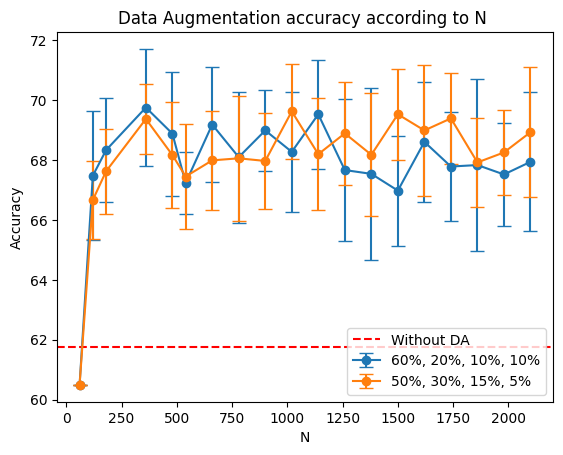

In [18]:
N =[ 60, 120, 180, 360, 480, 540, 660,  780, 900, 1020, 1140, 1260, 1380, 1500, 1620, 1740, 1860, 1980, 2100 ]

fig, ax = plt.subplots()


ax.errorbar(N, acc_N[0, :], yerr=acc_std[0, :], fmt='-o', capsize=5, label=f'60%, 20%, 10%, 10%')
ax.errorbar(N, acc_N[1, :], yerr=acc_std[1, :], fmt='-o', capsize=5, label=f'50%, 30%, 15%, 5%')

ax.axhline(y=61.76, color='r', linestyle='--', label='Without DA')
ax.set_xlabel('N')
ax.set_ylabel('Accuracy')
ax.set_title('Data Augmentation accuracy according to N ')
ax.legend()
plt.show()

# STEP 3

Añade ruido a picos con intensidades igual a cero para tratar de imitar las diferencias entre máquinas. Varias desviaciones del ruido

In [19]:
stds = [0.01, 0.05, 0.1, 0.2]

In [20]:

rf = RandomForestClassifier(random_state=42, n_estimators=150)
loo = LeaveOneOut()

acc_N = np.zeros((len(stds), len(Nshifts)))
acc_std = np.zeros((len(stds), len(Nshifts)))

for i, std in enumerate(stds):
    for j, n in enumerate(Nshifts):
        accuracies_combined = []  
        for _ in range(100):

            spec1C_mz = []
            spec1C_intensity = []

            for s in baseline:

                # Preprocessing: Variance stab., smoother, baseline removal, intensity calibration (TIC), trimming
                sO_s1 = varianceStabilizer(s)
                sO_s1 = smoother(sO_s1)
                sO_s1 = baselineRemove(sO_s1)
                sO_s1 = intensityCalibration(sO_s1)
                sO_s1 = trimming(sO_s1)
                # Binning
                sO_s1 = binner(sO_s1)

                spec1C_mz.append(np.array(sO_s1.mz))
                spec1C_intensity.append(np.array(sO_s1.intensity))

            spec1C_mz = np.array(spec1C_mz)
            spec1C_intensity = np.array(spec1C_intensity)

            augmented_spec1C_intensity = []
            augmented_spec1C_mz = []
            augmented_labels = []

            for mz, intensity, label in zip(spec1C_mz, spec1C_intensity, Y_train):
                index = [index for index, valor in enumerate(intensity) if valor == 0]
                int_modificados = []
                mz_modificados = []
                Y_modificados = []

                for _ in range(n):
                    intensidades_modificadas = intensity.copy()
                    
                    for pos in index:
                        ruido = np.random.normal(loc=0, scale=std)
                        intensidades_modificadas[pos] += ruido

                    int_modificados.append(intensidades_modificadas)
                    mz_modificados.append(mz)
                    Y_modificados.append(label)

                augmented_spec1C_intensity.append(intensity)
                augmented_spec1C_intensity.extend(int_modificados)
                augmented_spec1C_mz.append(mz)
                augmented_spec1C_mz.extend(mz_modificados)
                augmented_labels.append(label)
                augmented_labels.extend(Y_modificados)

            spec1C_mz = np.array(augmented_spec1C_mz)
            spec1C_intensity = np.array(augmented_spec1C_intensity)
            labels_1C = np.array(augmented_labels).reshape(-1, 1)

            # Entrenar el modelo
            rf.fit(spec1C_intensity, labels_1C.ravel())

            # Evaluación del modelo
            #X_combined = np.concatenate([spec1C_intensity, specTest_intensity])
            #Y_combined = np.concatenate([labels_1C.ravel(), Y_test.ravel()])
            combined_score = rf.score(specTest_intensity, Y_test.ravel())
            accuracies_combined.append(combined_score)
            #accuracies_combined2.append(rf.score(spec1C_intensity, labels_1C))

       
        mean_accuracy = 100 * np.mean(accuracies_combined)
        std_accuracy = 100 * np.sqrt(np.var(accuracies_combined))
        print("The combined LOO accuracy on week 1 and week 2 is %2.2f ± %2.2f" % (mean_accuracy, std_accuracy))
        
        acc_N[i, j] = mean_accuracy
        acc_std[i, j] = std_accuracy


The combined LOO accuracy on week 1 and week 2 is 60.49 ± 0.00
The combined LOO accuracy on week 1 and week 2 is 66.22 ± 1.02
The combined LOO accuracy on week 1 and week 2 is 67.55 ± 0.83
The combined LOO accuracy on week 1 and week 2 is 72.02 ± 0.86
The combined LOO accuracy on week 1 and week 2 is 70.25 ± 1.11
The combined LOO accuracy on week 1 and week 2 is 69.40 ± 1.09
The combined LOO accuracy on week 1 and week 2 is 68.16 ± 1.02
The combined LOO accuracy on week 1 and week 2 is 67.89 ± 0.94
The combined LOO accuracy on week 1 and week 2 is 70.10 ± 0.82
The combined LOO accuracy on week 1 and week 2 is 70.61 ± 0.94
The combined LOO accuracy on week 1 and week 2 is 71.17 ± 0.91
The combined LOO accuracy on week 1 and week 2 is 69.56 ± 0.81
The combined LOO accuracy on week 1 and week 2 is 71.61 ± 0.63
The combined LOO accuracy on week 1 and week 2 is 69.93 ± 0.67
The combined LOO accuracy on week 1 and week 2 is 71.17 ± 0.70
The combined LOO accuracy on week 1 and week 2 is 69.60

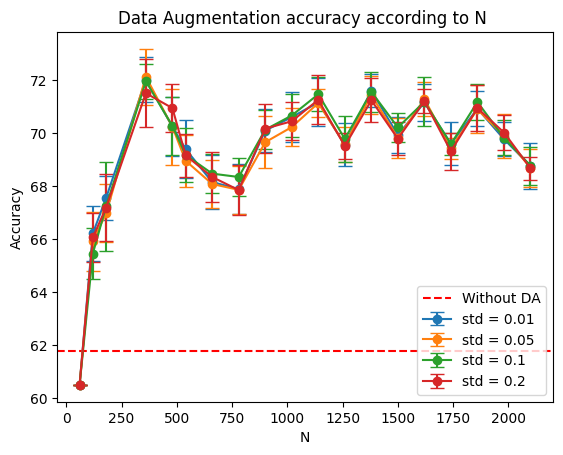

In [21]:

N =[ 60, 120, 180, 360, 480, 540, 660,  780, 900, 1020, 1140, 1260, 1380, 1500, 1620, 1740, 1860, 1980, 2100 ]
fig, ax = plt.subplots()

for i, std in enumerate(stds):  
    ax.errorbar(N, acc_N[i, :], yerr=acc_std[i, :], fmt='-o', capsize=5, label=f'std = {std}')

ax.axhline(y=61.76, color='r', linestyle='--', label='Without DA')
ax.set_xlabel('N')
ax.set_ylabel('Accuracy')
ax.set_title('Data Augmentation accuracy according to N ')
ax.legend()
plt.show()

# STEP 1 + STEP 2 + STEP 3

In [22]:
stds = [0.05]
Nshifts = [0, 1, 2,  6, 10, 16, 20,  26, 30, 36, 40, 46, 50, 56, 60, 66]


In [23]:

rf = RandomForestClassifier(random_state=42, n_estimators=200)
loo = LeaveOneOut()

acc_N = np.zeros((len(stds), len(Nshifts)))
acc_std = np.zeros((len(stds), len(Nshifts)))


for i, std in enumerate(stds):
    for j, n in enumerate(Nshifts):
        accuracies_combined = []
          
        for _ in range(100):

            spec1C_mz = []
            spec1C_intensity = []

            for s in baseline:
                
                # Preprocessing: Variance stab., smoother, baseline removal, intensity calibration (TIC), trimming
                sO_s1 = varianceStabilizer(s)
                sO_s1 = smoother(sO_s1)
                sO_s1 = baselineRemove(sO_s1)
                sO_s1 = intensityCalibration(sO_s1)
                sO_s1 = trimming(sO_s1)
                # Binning
                sO_s1 = binner(sO_s1)

                spec1C_mz.append(np.array(sO_s1.mz))
                spec1C_intensity.append(np.array(sO_s1.intensity))

            spec1C_mz = np.array(spec1C_mz)
            spec1C_intensity = np.array(spec1C_intensity)

            augmented_spec1C_intensity = []
            augmented_spec1C_mz = []
            augmented_labels = []
            n_shift = spec1C_mz.shape[1]
            n_50 = int(n_shift * 0.50)
            n_30 = int(n_shift * 0.30)
            n_15 = int(n_shift * 0.15)
            n_5 = int(n_shift * 0.05)
            # Permutar aleatoriamente los índices para seleccionarlos
            indices = np.random.permutation(n_shift)
            indices_50 = indices[:n_50]
            indices_30 = indices[n_50:n_50 + n_30]
            indices_15 = indices[n_50 + n_30:n_50 + n_30 + n_15]
            indices_5 = indices[n_50 + n_30 + n_15:]

            for mz, intensity, label in zip(spec1C_mz, spec1C_intensity, Y_train):
                index1 = stepOne(intensity, 0.75)
                index2 = [index for index, valor in enumerate(intensity) if valor == 0]
                int_modificados = []
                mz_modificados = []
                Y_modificados = []
                shifted_mz  = mz.copy()
                # Desplazar el 30% en ±3 Da
                desplazamiento_20 = np.random.uniform(-3, 3, size=n_30)
                shifted_mz[indices_30] += desplazamiento_20

                # Desplazar el 15% en ±60 Da
                desplazamiento_10_1 = np.random.uniform(-6, 6, size=n_15)
                shifted_mz[indices_15] += desplazamiento_10_1

                # Desplazar el último 5% en ±9 Da
                desplazamiento_10_2 = np.random.uniform(-9, 9, size=n_5)
                shifted_mz[indices_5] += desplazamiento_10_2

                interpolated = np.interp(mz, shifted_mz, intensity, left=0, right=0)

                for _ in range(n):
                    intensidades_modificadas = interpolated.copy()
                    
                    for pos1, pos2 in zip(index1, index2):
                        ruido1 = np.random.normal(loc=0, scale=std) * interpolated[pos1]
                        ruido2 = np.random.normal(loc=0, scale=0.01)
                        intensidades_modificadas[pos1] += ruido1
                        intensidades_modificadas[pos2] += ruido2

                    int_modificados.append(intensidades_modificadas)
                    mz_modificados.append(mz)
                    Y_modificados.append(label)

                augmented_spec1C_intensity.append(intensity)
                augmented_spec1C_intensity.extend(int_modificados)
                augmented_spec1C_mz.append(mz)
                augmented_spec1C_mz.extend(mz_modificados)
                augmented_labels.append(label)
                augmented_labels.extend(Y_modificados)

            spec1C_mz = np.array(augmented_spec1C_mz)
            spec1C_intensity = np.array(augmented_spec1C_intensity)
            labels_1C = np.array(augmented_labels).reshape(-1, 1)

            # Entrenar el modelo
            rf.fit(spec1C_intensity, labels_1C.ravel())
            

            # Evaluación del modelo
            #X_combined = np.concatenate([spec1C_intensity, specTest_intensity])
            #Y_combined = np.concatenate([labels_1C.ravel(), Y_test.ravel()])
            combined_score = rf.score(specTest_intensity, Y_test.ravel())
            accuracies_combined.append(combined_score)

        mean_accuracy = 100 * np.mean(accuracies_combined)
        std_accuracy = 100 * np.sqrt(np.var(accuracies_combined))
        print("The combined LOO accuracy on week 1 and week 2 is %2.2f ± %2.2f" % (mean_accuracy, std_accuracy))
        
        acc_N[i, j] = mean_accuracy
        acc_std[i, j] = std_accuracy


The combined LOO accuracy on week 1 and week 2 is 63.92 ± 0.00
The combined LOO accuracy on week 1 and week 2 is 68.07 ± 1.81
The combined LOO accuracy on week 1 and week 2 is 69.00 ± 1.68
The combined LOO accuracy on week 1 and week 2 is 69.75 ± 2.32
The combined LOO accuracy on week 1 and week 2 is 68.48 ± 2.14
The combined LOO accuracy on week 1 and week 2 is 69.73 ± 1.92
The combined LOO accuracy on week 1 and week 2 is 69.48 ± 1.83
The combined LOO accuracy on week 1 and week 2 is 69.18 ± 2.07
The combined LOO accuracy on week 1 and week 2 is 68.79 ± 2.20
The combined LOO accuracy on week 1 and week 2 is 69.05 ± 2.08
The combined LOO accuracy on week 1 and week 2 is 69.33 ± 2.00
The combined LOO accuracy on week 1 and week 2 is 69.18 ± 1.92
The combined LOO accuracy on week 1 and week 2 is 68.87 ± 1.92
The combined LOO accuracy on week 1 and week 2 is 68.87 ± 1.92
The combined LOO accuracy on week 1 and week 2 is 69.19 ± 2.00
The combined LOO accuracy on week 1 and week 2 is 68.70

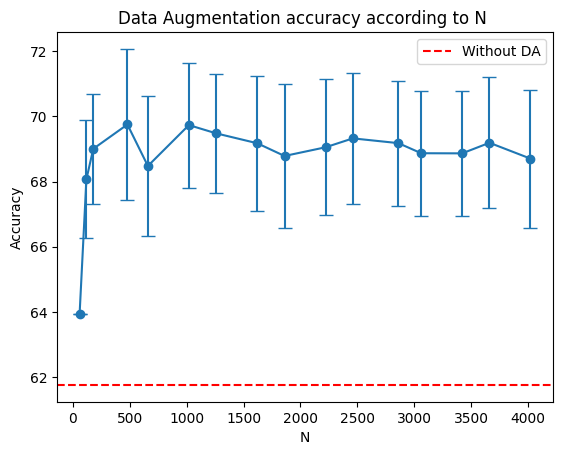

In [24]:
N =[60, 120, 180, 480, 660, 1020, 1260, 1620, 1860, 2220, 2460, 2860, 3060, 3420, 3660, 4020 ]


fig, ax = plt.subplots()

for i, std in enumerate(stds):  
    ax.errorbar(N, acc_N[i, :], yerr=acc_std[i, :], fmt='-o', capsize=5)

ax.axhline(y=61.76, color='r', linestyle='--', label='Without DA')
ax.set_xlabel('N')
ax.set_ylabel('Accuracy')
ax.set_title('Data Augmentation accuracy according to N ')
ax.legend()
plt.show()